Hyperparameter tuning

In [1]:
from CBF.cbf_recommender import cbf_recommender
from utils.evaluator.evaluator import evaluator
from utils.submission_helper import submission_helper
from utils.data_manager.data_manager import data_manager
from utils.data_manager.splitter import splitter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Now I'm trying to discover the best similarity heuristic and also if there is a dependency on the k parameter

In [2]:
training, validation, test = splitter().get_train_evaluation_test(percentage_of_training_data=0.6,
                                                                  percentage_of_validation_data=0.2)

In [3]:
k = [100, 250, 400]
similarities = ['pearson', 'cosine', 'adjusted', 'asymmetric', 'jaccard', 'tanimoto',
                             'dice', 'tversky']
map_vectors = []
for chosen_k in k:
    map_vector = []
    for chosen_similarity in similarities:
        recommender = cbf_recommender()
        recommender.fit(training, k=chosen_k, normalize=True, similarity=chosen_similarity)
        map_vector.append(evaluator.evaluate_already_trained(recommender=recommender)[2])
    map_vectors.append(map_vector)
index = 0
for vector in map_vectors:
    print("k: ", k[index], "map: ", vector, "similarities: ", similarities)
    index+=1

Similarity column 25975 ( 100 % ), 1190.54 column/sec, elapsed time 0.36 min
Similarity column 25975 ( 100 % ), 1349.54 column/sec, elapsed time 0.32 min
Similarity column 25975 ( 100 % ), 1259.20 column/sec, elapsed time 0.34 min
Similarity column 25975 ( 100 % ), 1344.53 column/sec, elapsed time 0.32 min
Similarity column 25975 ( 100 % ), 1193.81 column/sec, elapsed time 0.36 min
Similarity column 25975 ( 100 % ), 1086.71 column/sec, elapsed time 0.40 min
Similarity column 25975 ( 100 % ), 1319.21 column/sec, elapsed time 0.33 min
Similarity column 25975 ( 100 % ), 948.61 column/sec, elapsed time 0.46 min
Similarity column 25975 ( 100 % ), 1273.36 column/sec, elapsed time 0.34 min
Similarity column 25975 ( 100 % ), 1118.93 column/sec, elapsed time 0.39 min
Similarity column 25975 ( 100 % ), 947.72 column/sec, elapsed time 0.46 min
Similarity column 25975 ( 100 % ), 1237.85 column/sec, elapsed time 0.35 min
Similarity column 25975 ( 100 % ), 1113.37 column/sec, elapsed time 0.39 min
S

Similarity column 25975 ( 100 % ), 992.93 column/sec, elapsed time 0.44 min
Similarity column 25975 ( 100 % ), 896.71 column/sec, elapsed time 0.48 min
Similarity column 25975 ( 100 % ), 1012.72 column/sec, elapsed time 0.43 min
Similarity column 25975 ( 100 % ), 868.81 column/sec, elapsed time 0.50 min
Similarity column 23900 ( 92 % ), 796.58 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 797.58 column/sec, elapsed time 0.54 min
Similarity column 25975 ( 100 % ), 948.38 column/sec, elapsed time 0.46 min
Similarity column 25975 ( 100 % ), 936.75 column/sec, elapsed time 0.46 min
Similarity column 25975 ( 100 % ), 904.67 column/sec, elapsed time 0.48 min
Similarity column 25975 ( 100 % ), 909.35 column/sec, elapsed time 0.48 min
Similarity column 25300 ( 97 % ), 842.66 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 841.67 column/sec, elapsed time 0.51 min
Similarity column 24200 ( 93 % ), 804.52 column/sec, elapsed time 0.50 min
Similarity col

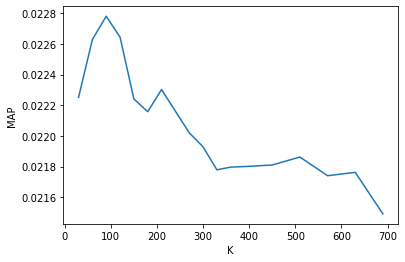

In [4]:
k_tested = [i for i in range(30,400,30)]
k1 = [i for i in range(450, 700, 60)]
k_tested = k_tested + k1
map_=[]
for k in k_tested:
    recommender = cbf_recommender()
    recommender.fit(training, k=k, normalize=True, similarity='jaccard')
    map_.append(evaluator.evaluate_already_trained(recommender=recommender)[2])
plt.plot(k_tested, map_)
plt.ylabel('MAP')
plt.xlabel('K')
plt.show()

In [5]:
k = k_tested[np.argmax(map_)]
k

90

In [6]:
recommender_to_test = cbf_recommender()
recommender_to_test.fit(training_set=data_manager().get_urm(), k=90, shrink=100)
submission_helper(recommender=recommender_to_test, name_of_the_file="first_cbf").build_submission()

Similarity column 25975 ( 100 % ), 935.01 column/sec, elapsed time 0.46 min
